# Heart Rate Prediction

Assumptions: series don't impact each other.

Not all readings start at exactly 30 seconds. We will shift to align all series on 30 second intervals

Need to figure out discontinuities

Key Considerations:
- Probabilistic: need a range of outcomes, not just point estimates
- Explainability: want to be able to understand why the model is making predictions
- Speed: some design choices were made under time constraints that may not be applicable to a live app setting

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

In [2]:
data = pd.read_csv('data/dataset_for_ds_candidate.csv',
                    usecols = ['ID',
                              'TIME_SINCE_START_IN_SECONDS',
                              'CW_SIGNAL_TYPE',
                              'SIGNAL_VALUE'])

### Inspect Data

In [3]:
print(data.head(5))
print(data.tail(5))


   ID  TIME_SINCE_START_IN_SECONDS CW_SIGNAL_TYPE  SIGNAL_VALUE
0   1                           30             HR         112.0
1   1                           60             HR         112.0
2   1                           90             HR         113.0
3   1                          120             HR         111.0
4   1                          150             HR         112.0
          ID  TIME_SINCE_START_IN_SECONDS CW_SIGNAL_TYPE  SIGNAL_VALUE
2546264  147                        75515           SPO2          95.0
2546265  147                        75545           SPO2          95.0
2546266  147                        75605           SPO2          94.0
2546267  147                        75635           SPO2          94.0
2546268  147                        75664           SPO2          94.0


In [4]:
print(data.describe())

                 ID  TIME_SINCE_START_IN_SECONDS  SIGNAL_VALUE
count  2.546269e+06                 2.546269e+06  2.546269e+06
mean   7.248366e+01                 2.892031e+05  8.926851e+01
std    3.951853e+01                 3.189487e+05  1.461936e+01
min    1.000000e+00                 2.900000e+01  0.000000e+00
25%    4.000000e+01                 7.284100e+04  8.000000e+01
50%    6.500000e+01                 1.787590e+05  9.400000e+01
75%    1.080000e+02                 3.889030e+05  9.800000e+01
max    1.470000e+02                 2.005009e+06  2.420000e+02


### Initial Impressions
We appear to have a dataset that takes 2 signals (HR, SP02) from patients (ID) at 30 second intervals (TIME_SINCE_START_IN_SECONDS). Immediately, we need to do some data quality checks to ensure that we can work with the data:


1) We need to ensure the time steps are evenly spaced for our time series models to work (note that some records are 29 seconds apart) and we need to handle the gaps

2) For each ID/CW_SIGNAL_TYPE combination, we need exactly one reading at each time step

Let's transform the data to make it a little bit easier to work with

## Transform - Start

In [5]:
data_pvt = data.pivot_table(index=['ID','TIME_SINCE_START_IN_SECONDS'],
           columns='CW_SIGNAL_TYPE',
           values=['SIGNAL_VALUE'],
           aggfunc='mean') # when there are duplicates, we take the average

data_pvt['SIGNAL_VALUE']['HR'].isna().sum()/data_pvt.shape[0] # so we have 3,164 records where we have an SPO2 reading but not an HR reading

# data_pvt['SIGNAL_VALUE']['SPO2'].isna().sum()/data_pvt.shape[0] # 9 percent of HR readings don't have SPO2. How to handle missing?

0.0023723298168267463

For this to work, we need regular, complete intervals. 

In [6]:
data_pvt.columns = ['_'.join(col) for col in data_pvt.columns.values]
data_pvt.head()

SIGNAL_VALUE_HR  SIGNAL_VALUE_SPO2
ID TIME_SINCE_START_IN_SECONDS                                    
1  30                                     112.0               98.0
   60                                     112.0               99.0
   90                                     113.0               98.0
   120                                    111.0               99.0
   150                                    112.0               98.0

In [7]:
data_pvt2 = data_pvt.reset_index(level=[1])

data_pvt2['time_diff'] = data_pvt2.groupby(level=0)['TIME_SINCE_START_IN_SECONDS'].diff()
# # fill na with 0
data_pvt2['time_diff'] = data_pvt2['time_diff'].fillna(0)
data_pvt2['time_step'] = (data_pvt2['time_diff'] / 30).round().astype(int)
# data_pvt2.loc[data_pvt2['time_step']>1]
data_pvt2['n_time_steps'] =  data_pvt2.groupby(level=0)['time_step'].cumsum()
# data_pvt2.head()
data_pvt2.info()
data_pvt2[15:30]

<class 'pandas.core.frame.DataFrame'>
Index: 1333710 entries, 1 to 147
Data columns (total 6 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   TIME_SINCE_START_IN_SECONDS  1333710 non-null  int64  
 1   SIGNAL_VALUE_HR              1330546 non-null  float64
 2   SIGNAL_VALUE_SPO2            1215538 non-null  float64
 3   time_diff                    1333710 non-null  float64
 4   time_step                    1333710 non-null  int64  
 5   n_time_steps                 1333710 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 71.2 MB


,TIME_SINCE_START_IN_SECONDS,SIGNAL_VALUE_HR,SIGNAL_VALUE_SPO2,time_diff,time_step,n_time_steps
ID,,,,,,
1,480,114.0,98.0,30.0,1,15
1,510,114.0,99.0,30.0,1,16
1,540,112.0,99.0,30.0,1,17
1,570,112.0,99.0,30.0,1,18
1,599,115.0,96.0,29.0,1,19
1,629,113.0,100.0,30.0,1,20
1,660,114.0,98.0,31.0,1,21
1,690,115.0,98.0,30.0,1,22
1,720,114.0,99.0,30.0,1,23


In [8]:
data_pvt3 = data_pvt2.reset_index()
data_pvt3.head()
id_time_range = (
    data_pvt3.reset_index().groupby('ID')['n_time_steps']
    .apply(lambda x: pd.RangeIndex(start=x.min(), stop=x.max() + 1,step=1))
    .explode()
    .reset_index()
    .rename(columns={0: 'n_time_steps'})
)
id_time_range
# # Create a full index of id and time
full_index = id_time_range.merge(data_pvt3[['ID']].drop_duplicates(), on='ID')
# full_index.groupby('ID')['n_time_steps'].agg(['min','max']).to_csv('./data/series_ranges.csv')

In [9]:
df_filled = (
    full_index.merge(data_pvt3, on=['ID', 'n_time_steps'], how='left')
    .sort_values(['ID', 'n_time_steps'])
)

df_filled['SIGNAL_VALUE_HR'].isna().sum()/df_filled.shape[0] 

# 6% of our records are missing which suggests we have some gaps
# cases where there are multiple readings within a 30 second window!
df_filled_agg = df_filled.groupby(['ID','n_time_steps']).agg('mean').reset_index()


In [10]:
df_filled_agg.loc[df_filled_agg['SIGNAL_VALUE_HR'].notna() & df_filled_agg['SIGNAL_VALUE_SPO2'].isna(), 'SIGNAL_VALUE_SPO2'] = df_filled_agg['SIGNAL_VALUE_SPO2'].mean()

In [11]:
# num_imputed = df_filled_agg.loc[df_filled_agg['SIGNAL_VALUE_HR'].notna() & df_filled_agg['SIGNAL_VALUE_SPO2'].isna(), 'SIGNAL_VALUE_SPO2'].shape[0]
# num_hr = df_filled_agg.loc[df_filled_agg['SIGNAL_VALUE_HR'].notna(), 'SIGNAL_VALUE_SPO2'].shape[0]

In [12]:
# example of multiple readings w/in 30 second window
# check = df_filled.groupby(['ID','n_time_steps'])['n_time_steps'].agg('count')
# check.loc[check.values>1]

# data.loc[(data['ID']==8) & (abs(data['TIME_SINCE_START_IN_SECONDS'] - 8457*30) < 300)]

<Axes: xlabel='n_time_steps'>

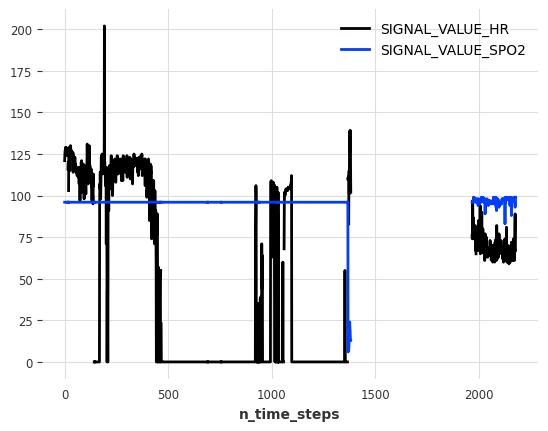

In [13]:
from darts import TimeSeries
ts_g = TimeSeries.from_group_dataframe(df_filled_agg,
                                       group_cols=['ID'],
                               time_col='n_time_steps',
                               value_cols=['SIGNAL_VALUE_HR',
                                           'SIGNAL_VALUE_SPO2']
                                     )
# 
ts_g[139]['SIGNAL_VALUE_HR'].plot()
ts_g[139]['SIGNAL_VALUE_SPO2'].plot()

In [14]:
ts_g[139].pd_dataframe()[500:]

component,SIGNAL_VALUE_HR,SIGNAL_VALUE_SPO2
n_time_steps,,
500,0.0,96.009767
501,0.0,96.009767
502,0.0,96.009767
503,0.0,96.009767
504,0.0,96.009767
...,...,...
2174,72.0,98.000000
2175,77.0,96.000000
2176,89.0,93.000000


In [15]:
ts_g[140]

<TimeSeries (DataArray) (n_time_steps: 14857, component: 2, sample: 1)> Size: 238kB
array([[[        nan],
        [99.        ]],

       [[69.        ],
        [99.        ]],

       [[69.        ],
        [96.00976658]],

       ...,

       [[59.        ],
        [96.        ]],

       [[59.        ],
        [97.        ]],

       [[60.        ],
        [96.00976658]]])
Coordinates:
  * n_time_steps  (n_time_steps) int64 119kB 0 1 2 3 ... 14853 14854 14855 14856
  * component     (component) object 16B 'SIGNAL_VALUE_HR' 'SIGNAL_VALUE_SPO2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates     ID\nglobal_components  141.0
    hierarchy:          None

In [16]:
# gaps
# approach: fill gaps up to certain point n
# take longest contiguous series
# track number of records lost

# I considered breaking up until multiple series, but in interest of time chose the former approach
# the reason is i didn't want to predict on interpolated values
gap_list = [ts.gaps() for ts in ts_g]

gap_df = pd.concat(gap_list)


gap_df['gap_size'].quantile([.5,.8,.9,.95])





0.50     1.0
0.80     2.0
0.90     7.0
0.95    33.6
Name: gap_size, dtype: float64

In [17]:
# test fill missing limit
from darts.dataprocessing.transformers import MissingValuesFiller

transformer = MissingValuesFiller()
print(ts_g[7].n_timesteps)
gap_test = transformer.transform(ts_g,limit = 10) 



19908


In [18]:
gap_df = gap_test[19].gaps()
gap_df['lag_end'] = gap_df['gap_end'].shift(1,fill_value=0)
gap_df

,gap_start,gap_end,gap_size,lag_end
0,1766,1871,106,0
1,13172,13206,35,1871
2,16286,16309,24,13206
3,24340,30325,5986,16309


In [19]:
split_test = gap_test[19].split_before(1766)
split_test[1].end_time()
gap_test[19].slice(0,1766)

<TimeSeries (DataArray) (n_time_steps: 1766, component: 2, sample: 1)> Size: 28kB
array([[[74.        ],
        [97.        ]],

       [[74.        ],
        [99.        ]],

       [[76.        ],
        [99.        ]],

       ...,

       [[79.18897638],
        [96.00976658]],

       [[79.21259843],
        [96.00976658]],

       [[79.23622047],
        [96.00976658]]])
Coordinates:
  * component     (component) object 16B 'SIGNAL_VALUE_HR' 'SIGNAL_VALUE_SPO2'
  * n_time_steps  (n_time_steps) int64 14kB 0 1 2 3 4 ... 1762 1763 1764 1765
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates    ID\nglobal_components  20.0
    hierarchy:          None

In [20]:
gap_test[19].static_covariates['ID'][0]

20.0

In [21]:
split_list = []
for idx,row in gap_df.iterrows():
    split = gap_test[19].slice(row['lag_end'],row['gap_start'])
    print(f'adding a time series from {split.start_time()} to {split.end_time()}')
    split_list.append(split)

len(split_list)

adding a time series from 0 to 1765
adding a time series from 1871 to 13171
adding a time series from 13206 to 16285
adding a time series from 16309 to 24339


4

In [22]:
gap_test[139].gaps()

,gap_start,gap_end,gap_size
0,1393,1957,565


In [23]:
def is_notnull_SPO2(ts):
    return bool(ts['SIGNAL_VALUE_SPO2'].pd_dataframe().notnull().any()[0])

def is_ts_sufficient(ts):
    return ts.n_timesteps > 100

def is_SPO2_sufficient(ts):
    return ts['SIGNAL_VALUE_SPO2'].pd_dataframe().isnull().sum()[0]/ts.n_timesteps < .85

def ts_checks(ts):
    if is_notnull_SPO2(ts) and is_ts_sufficient(ts) and is_SPO2_sufficient(ts):
        return True
    else:
        print('series has issue')
        return False


In [24]:
ts_g = []
for ts in gap_test:
    series_id = ts.static_covariates['ID'][0]
    if ts.gaps().shape[0] == 0:
        print(f'Series {series_id} has no gaps')
        if ts_checks(ts):
            ts_g.append(ts)
    else:
        
        gap_df = ts.gaps()
        print(f'Series {series_id} has {gap_df.shape[0]} gaps')
        gap_df['lag_end'] = gap_df['gap_end'].shift(1,fill_value=0)
        for idx,row in gap_df.iterrows():
            split = ts.slice(row['lag_end'],row['gap_start'])
            print(f'adding a time series from {split.start_time()} to {split.end_time()}')
            if ts_checks(split):
                ts_g.append(split)
        last_gap_end = int(gap_df['gap_end'].iat[-1])
        final_split = ts.slice(last_gap_end,ts.n_timesteps)
        if ts_checks(final_split):
            print(f'adding a time series from {last_gap_end} to {ts.n_timesteps}')
            ts_g.append(final_split)


ts_g = [ts for ts in ts_g if ts.n_timesteps > 120 & bool(ts['SIGNAL_VALUE_SPO2'].pd_dataframe().notnull().any()[0])]

Series 1.0 has no gaps
Series 2.0 has 1 gaps
adding a time series from 0 to 5092
series has issue
Series 3.0 has 1 gaps
adding a time series from 0 to 2693
series has issue
Series 4.0 has no gaps
Series 5.0 has 1 gaps
adding a time series from 0 to 7214
adding a time series from 7249 to 10301
Series 6.0 has no gaps
Series 7.0 has no gaps
Series 8.0 has 2 gaps
adding a time series from 0 to 3093
adding a time series from 3297 to 10339
adding a time series from 10674 to 19908
Series 9.0 has no gaps
Series 10.0 has 1 gaps
adding a time series from 0 to 313
adding a time series from 459 to 2823
Series 11.0 has no gaps
Series 12.0 has 1 gaps
adding a time series from 0 to 5717
adding a time series from 5718 to 6135
Series 13.0 has 1 gaps
adding a time series from 0 to 4442
series has issue
Series 14.0 has 1 gaps
adding a time series from 0 to 1981
adding a time series from 2031 to 7854
Series 15.0 has 1 gaps
adding a time series from 0 to 1425
adding a time series from 1432 to 1644
Series 1

In [25]:
ts_g[0].head()

<TimeSeries (DataArray) (n_time_steps: 5, component: 2, sample: 1)> Size: 80B
array([[[112.],
        [ 98.]],

       [[112.],
        [ 99.]],

       [[113.],
        [ 98.]],

       [[111.],
        [ 99.]],

       [[112.],
        [ 98.]]])
Coordinates:
  * n_time_steps  (n_time_steps) int64 40B 0 1 2 3 4
  * component     (component) object 16B 'SIGNAL_VALUE_HR' 'SIGNAL_VALUE_SPO2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates   ID\nglobal_components  1.0
    hierarchy:          None

## Transform - End

## Exploratory Data Analysis

EDA Plan:
- Clean up:
    - Can't have duplicates by series, cw_signal_type, time_since_start_in_seconds
- Summary statistics
    - ID: 
        - Number of unique IDs
    - TIME_SINCE_START_IN_SECONDS
        - Distribution
        - Missing Values
        - Outliers
    - CW_SIGNAL_TYPE:
    - HR_SIGNAL_VALUE:
        - Distribution
        - Missing Values
        - Outliers
    - SPO2_SIGNAL_VALUE
        - Distribution
        - Missing Values
        - Outliers


Based on examining a few duplicates, we should just be able to take the average and be OK

### Univariate analysis on transformed data

#### ID

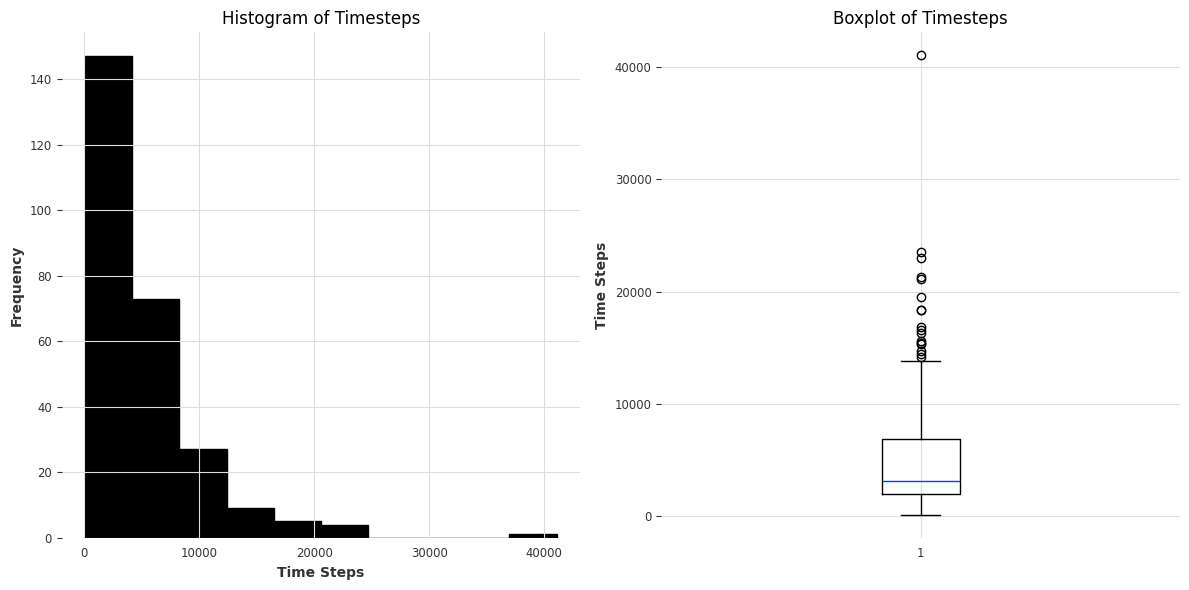

In [26]:
id_data = pd.DataFrame([(ts.static_covariates['ID'][0],ts.n_timesteps) for ts in ts_g],
                       columns=['ID','n_timesteps'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram
axes[0].hist(id_data['n_timesteps'], edgecolor='black')
axes[0].set_title('Histogram of Timesteps')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Frequency')

# Boxplot
axes[1].boxplot(id_data['n_timesteps'])
axes[1].set_title('Boxplot of Timesteps')
axes[1].set_ylabel('Time Steps')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [27]:
id_data.describe()

,ID,n_timesteps
count,266.000000,266.000000
mean,72.872180,5034.624060
std,42.157998,5053.434911
min,1.000000,104.000000
25%,36.250000,1967.250000
50%,69.000000,3087.000000
75%,111.750000,6832.500000
max,147.000000,41069.000000


In [28]:
# missing values

Notes about the ID:
We have 147 IDs that on average have about 9000 observations. I'm curious if heart rate trends up over time. Maybe the longer someone is at the hospital, the more likely they are to experience an adverse event

When we get to multi-variate analysis, I'll be looking for how much variation in heart rate within each series and how much variation there is between series

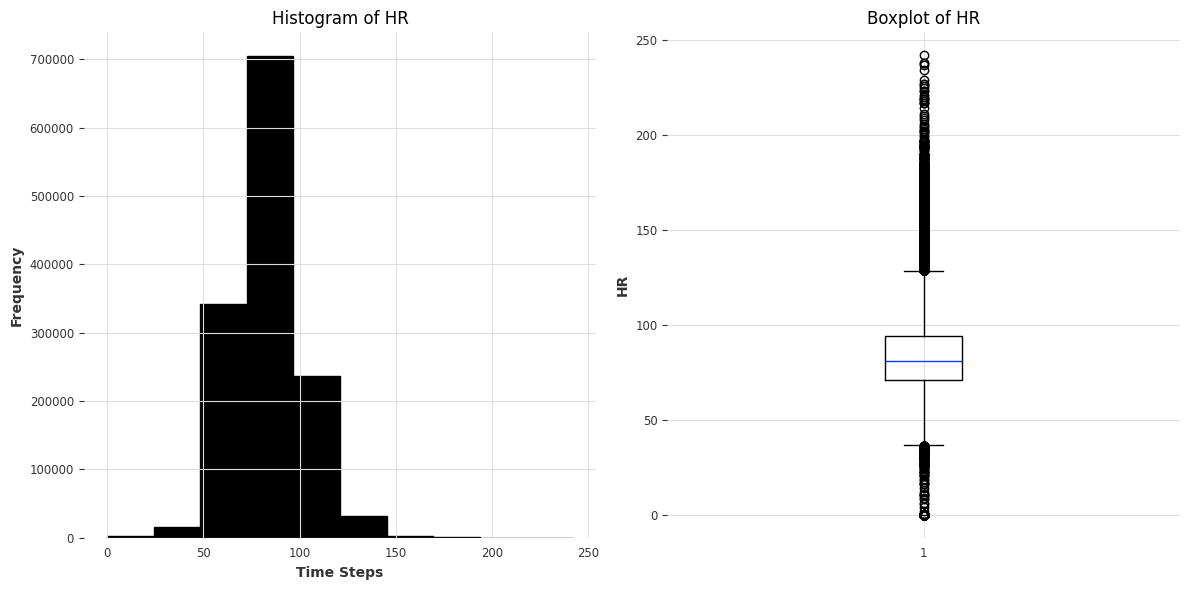

In [29]:
hr_data = pd.concat([ts['SIGNAL_VALUE_HR'].pd_dataframe() for ts in ts_g])

hr_data.describe()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # Histogram
axes[0].hist(hr_data['SIGNAL_VALUE_HR'], edgecolor='black')
axes[0].set_title('Histogram of HR')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Frequency')

# # Boxplot
axes[1].boxplot(hr_data.loc[~hr_data['SIGNAL_VALUE_HR'].isna()]['SIGNAL_VALUE_HR'])
axes[1].set_title('Boxplot of HR')
axes[1].set_ylabel('HR')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [30]:
hr_data.describe()

component,SIGNAL_VALUE_HR
count,1.338340e+06
mean,8.312624e+01
std,1.780013e+01
min,0.000000e+00
25%,7.100000e+01
50%,8.100000e+01
75%,9.400000e+01
max,2.420000e+02


#### SPO2

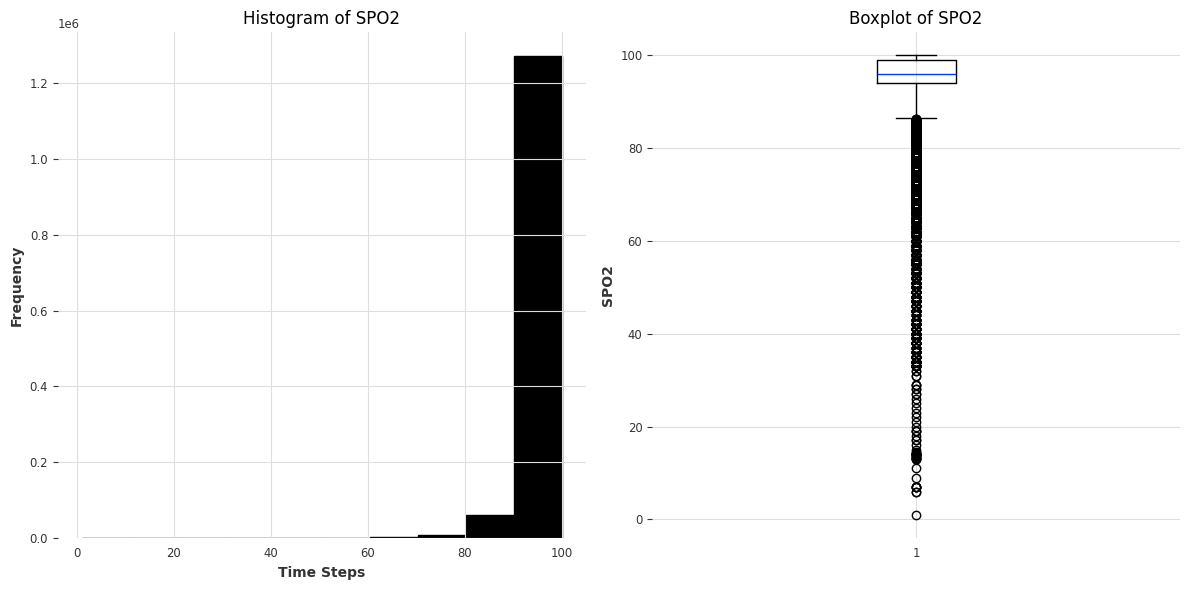

In [31]:
hr_data = pd.concat([ts['SIGNAL_VALUE_SPO2'].pd_dataframe() for ts in ts_g])

hr_data.describe()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # Histogram
axes[0].hist(hr_data['SIGNAL_VALUE_SPO2'], edgecolor='black')
axes[0].set_title('Histogram of SPO2')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Frequency')

# # Boxplot
axes[1].boxplot(hr_data.loc[~hr_data['SIGNAL_VALUE_SPO2'].isna()]['SIGNAL_VALUE_SPO2'])
axes[1].set_title('Boxplot of SPO2')
axes[1].set_ylabel('SPO2')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Multivariate Analysis

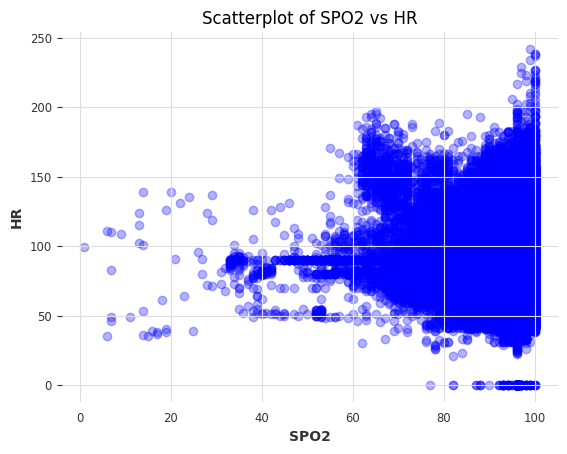

In [32]:
# correlation between HR and SP02
# correlation between lag HR and lag SPO2 - hypothesis: drop in SPO2 correlates with change in HR
df_filled_agg.head()

plt.scatter(df_filled_agg['SIGNAL_VALUE_SPO2'], 
            df_filled_agg['SIGNAL_VALUE_HR'],
            color = 'blue',
            alpha=0.3)

# Add labels and title
plt.xlabel('SPO2')
plt.ylabel('HR')
plt.title('Scatterplot of SPO2 vs HR')

# Show the plot
plt.show()

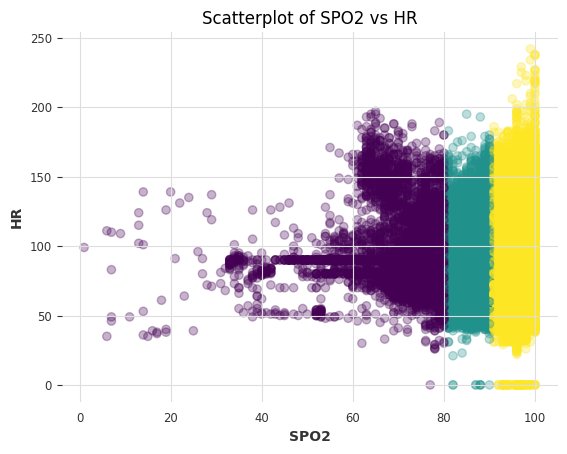

In [33]:
# add bins to SPO2
bins = [0, 80, 90, 1000]
labels = [1,2,3]
df_filled_agg['SPO2_binned'] = pd.cut(df_filled_agg['SIGNAL_VALUE_SPO2'], bins=bins, labels=labels)
df_filled_agg.loc[df_filled_agg['SIGNAL_VALUE_SPO2'] == 80].head()


plt.scatter(df_filled_agg['SIGNAL_VALUE_SPO2'], 
            df_filled_agg['SIGNAL_VALUE_HR'],
            c = df_filled_agg['SPO2_binned'],
            alpha=0.3)

# Add labels and title
plt.xlabel('SPO2')
plt.ylabel('HR')
plt.title('Scatterplot of SPO2 vs HR')

# Show the plot
plt.show()

No clear relationship, but variance is not constant

#### Stationarity

In [34]:
from darts.utils.statistics import stationarity_test_adf
from darts.dataprocessing.transformers import MissingValuesFiller

def cw_stationarity_tester(ts: TimeSeries) -> bool:
    """Fill """
    transformer = MissingValuesFiller()
    ts_tf = transformer.transform(ts) 
    # check: if statistic is below p-value, cannot reject null -> non-stationary
    test_res = stationarity_test_adf(ts_tf,
                                     maxlag=None,
                                     regression='c',
                                     autolag='AIC')
    
    if test_res[0] < test_res[4]['5%']:
        return True # stationary
    else:
        return False # non stationary
test_res = cw_stationarity_tester(ts_g[7]['SIGNAL_VALUE_HR'])
sum([cw_stationarity_tester(ts['SIGNAL_VALUE_HR']) for ts in ts_g])

/workspaces/ts-dl/.venv/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


184

Most of our series are stationary

#### Variance by hour of stay

## Data Preprocessing Pipeline

### Feature Engineering

#### Date/Time Related Features
Because we're given time since start in seconds, we don't have date or time related features. However, given that heart rates may fluctuate during sleep, maybe we should explore 24 cycles

#### Lags
Using darts, we will handle lags using an argument. What number of lags should we include?

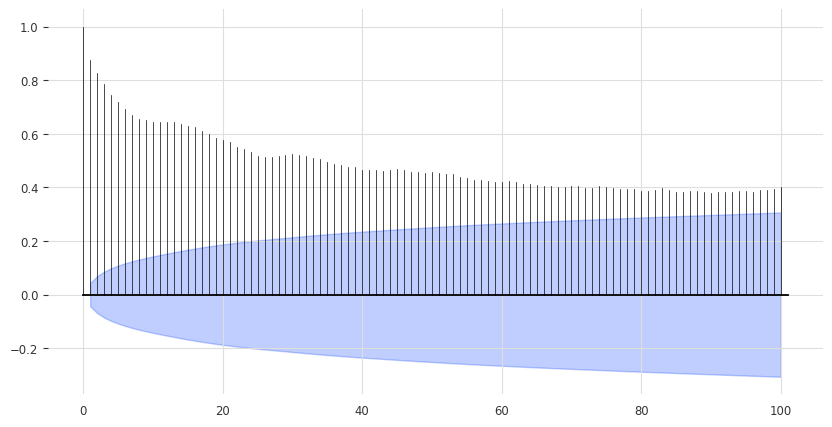

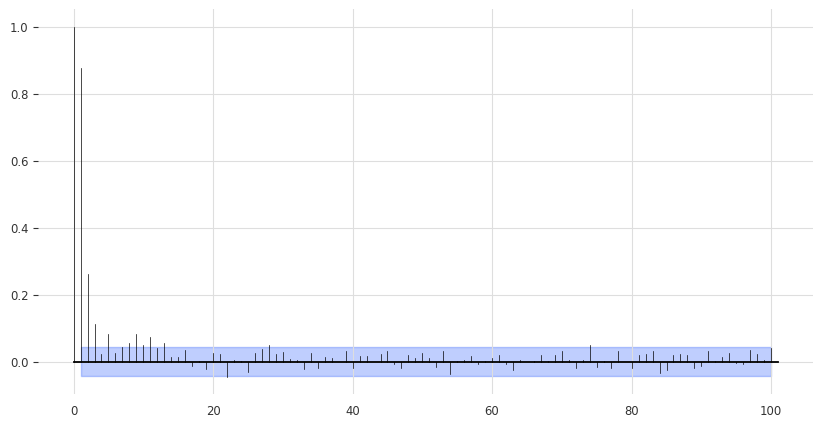

In [35]:
from darts.utils.statistics import check_seasonality, plot_acf, plot_pacf
# ts_g[0]['SIGNAL_VALUE_HR'].plot()
plot_acf(ts_g[2].head(2050)['SIGNAL_VALUE_HR'],max_lag=100)
plot_pacf(ts_g[2].head(2050)['SIGNAL_VALUE_HR'],max_lag=100)
# plot_pacf(ts_g[2].head(200)['SIGNAL_VALUE_HR'],m=10,max_lag=25)

#### Domain Specific Features

- From wikipedia: SPO2 is typically between 96-100. Below 90 is considered low and below 80 is considered dangerous
- Difference in expanding median and rolling average

In [36]:
def add_bin(ts):
    # convert to df
    test_df = ts.pd_dataframe().reset_index()
    # bin variable
    bins = [0, 80, 90, 1000]
    labels = [1,2,3]
    test_df['SPO2_binned'] = pd.cut(test_df['SIGNAL_VALUE_SPO2'], bins=bins, labels=labels)
    # stack new variable
    ts_add = TimeSeries.from_dataframe(test_df,time_col='n_time_steps',value_cols='SPO2_binned')
    ts_out = TimeSeries.stack(ts,ts_add)
    return ts_out

ts_g = [add_bin(ts) for ts in ts_g]

#### Rolling Window Features

In [37]:
from darts.dataprocessing.transformers import WindowTransformer
from darts.dataprocessing.pipeline import Pipeline
from darts.dataprocessing.transformers import Scaler

mv_transformer = MissingValuesFiller()

# rolling: mean, med, std, min, max, skew
# wtd: med, std
# exp wtd: med, std
# expanding: med, std, min, max, skew
# windows: 5,10,20,30,40,50,100

w_transformer = WindowTransformer(transforms=[{"function":"mean",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "window":10},
                                             {"function":"median",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "window":10},
                                             {"function":"std",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "treat_na":"dropna",
                                             "window":10},
                                             {"function":"min",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "window":10},
                                             {"function":"max",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "window":10},
                                             {"function":"skew",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "window":10}, # END ROLLING

                                             {"function":"median",
                                             "mode":"expanding",
                                            #  "components":"",
                                             "function_name":""},
                                              {"function":"std",
                                             "mode":"expanding",
                                            #  "components":"",
                                             "function_name":""},
                                             {"function":"min",
                                             "mode":"expanding",
                                            #  "components":"",
                                             "function_name":""},
                                             {"function":"max",
                                             "mode":"expanding",
                                            #  "components":"",
                                             "function_name":""},
                                             {"function":"skew",
                                             "mode":"expanding",
                                            #  "components":"",
                                             "function_name":""},
                                              {"function":"mean",
                                             "mode":"ewm",
                                            #  "components":"",
                                             "function_name":"",
                                             "alpha":0.5,
                                             "window":10},
                                             {"function":"std",
                                             "mode":"ewm",
                                             "alpha":0.5,
                                            #  "components":"",
                                             "function_name":"",
                                             "window":10},
                                             
                                             #### 50!
                                             {"function":"mean",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "window":50},
                                             {"function":"median",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "window":50},
                                             {"function":"std",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "treat_na":"dropna",
                                             "window":50},
                                             {"function":"min",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "window":50},
                                             {"function":"max",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "window":50},
                                             {"function":"skew",
                                             "mode":"rolling",
                                            #  "components":"",
                                             "function_name":"",
                                             "window":50}, # END ROLLING

                                             {"function":"median",
                                             "mode":"expanding",
                                            #  "components":"",
                                             "function_name":""},
                                              {"function":"std",
                                             "mode":"expanding",
                                            #  "components":"",
                                             "function_name":""},
                                             {"function":"min",
                                             "mode":"expanding",
                                            #  "components":"",
                                             "function_name":""},
                                             {"function":"max",
                                             "mode":"expanding",
                                            #  "components":"",
                                             "function_name":""},
                                             {"function":"skew",
                                             "mode":"expanding",
                                            #  "components":"",
                                             "function_name":""},
                                              {"function":"mean",
                                             "mode":"ewm",
                                            #  "components":"",
                                             "function_name":"",
                                             "alpha":0.5,
                                             "window":50},
                                             {"function":"std",
                                             "mode":"ewm",
                                             "alpha":0.5,
                                            #  "components":"",
                                             "function_name":"",
                                             "window":50},
                                             ],
                                             keep_non_transformed=True
                                             )


scaler = Scaler()  # default uses sklearn's MinMaxScaler

In [38]:
# pipeline
pipeline = Pipeline([w_transformer, # window transformations
                     mv_transformer, # missing values
                     ])
ts_tf = pipeline.fit_transform(ts_g)
# tf_test['SIGNAL_VALUE_HR'].plot()
ts_tf[0].pd_dataframe().isna().sum().sum()
# ts_tf[0]['SIGNAL_VALUE_SPO2'].plot()
# ts_tf[0]['rolling_mean_20_SIGNAL_VALUE_HR'].plot()
# ts_tf[0].pd_dataframe()

0

In [39]:
ts_tf[0].pd_dataframe().columns

Index(['rolling_mean_10_SIGNAL_VALUE_HR', 'rolling_mean_10_SIGNAL_VALUE_SPO2',
       'rolling_mean_10_SPO2_binned', 'rolling_median_10_SIGNAL_VALUE_HR',
       'rolling_median_10_SIGNAL_VALUE_SPO2', 'rolling_median_10_SPO2_binned',
       'rolling_std_10_SIGNAL_VALUE_HR', 'rolling_std_10_SIGNAL_VALUE_SPO2',
       'rolling_std_10_SPO2_binned', 'rolling_min_10_SIGNAL_VALUE_HR',
       'rolling_min_10_SIGNAL_VALUE_SPO2', 'rolling_min_10_SPO2_binned',
       'rolling_max_10_SIGNAL_VALUE_HR', 'rolling_max_10_SIGNAL_VALUE_SPO2',
       'rolling_max_10_SPO2_binned', 'rolling_skew_10_SIGNAL_VALUE_HR',
       'rolling_skew_10_SIGNAL_VALUE_SPO2', 'rolling_skew_10_SPO2_binned',
       'expanding_median_SIGNAL_VALUE_HR',
       'expanding_median_SIGNAL_VALUE_SPO2', 'expanding_median_SPO2_binned',
       'expanding_std_SIGNAL_VALUE_HR', 'expanding_std_SIGNAL_VALUE_SPO2',
       'expanding_std_SPO2_binned', 'expanding_min_SIGNAL_VALUE_HR',
       'expanding_min_SIGNAL_VALUE_SPO2', 'expanding_min_S

#### Add domain specific features

In [40]:
def mean_diff(ts):
    # convert to df
    test_df = ts.pd_dataframe().reset_index()
    # bin variable
    bins = [0, 80, 90, 1000]
    labels = [1,2,3]
    test_df['roll_mean_diff'] = test_df['rolling_median_10_SIGNAL_VALUE_HR'] - test_df['expanding_median_SIGNAL_VALUE_HR']
    # stack new variable
    ts_add = TimeSeries.from_dataframe(test_df,time_col='n_time_steps',value_cols='roll_mean_diff')
    ts_out = TimeSeries.stack(ts,ts_add)
    return ts_out

ts_tf = [mean_diff(ts) for ts in ts_tf]

In [41]:
ts_tf[0].pd_dataframe().columns

Index(['rolling_mean_10_SIGNAL_VALUE_HR', 'rolling_mean_10_SIGNAL_VALUE_SPO2',
       'rolling_mean_10_SPO2_binned', 'rolling_median_10_SIGNAL_VALUE_HR',
       'rolling_median_10_SIGNAL_VALUE_SPO2', 'rolling_median_10_SPO2_binned',
       'rolling_std_10_SIGNAL_VALUE_HR', 'rolling_std_10_SIGNAL_VALUE_SPO2',
       'rolling_std_10_SPO2_binned', 'rolling_min_10_SIGNAL_VALUE_HR',
       'rolling_min_10_SIGNAL_VALUE_SPO2', 'rolling_min_10_SPO2_binned',
       'rolling_max_10_SIGNAL_VALUE_HR', 'rolling_max_10_SIGNAL_VALUE_SPO2',
       'rolling_max_10_SPO2_binned', 'rolling_skew_10_SIGNAL_VALUE_HR',
       'rolling_skew_10_SIGNAL_VALUE_SPO2', 'rolling_skew_10_SPO2_binned',
       'expanding_median_SIGNAL_VALUE_HR',
       'expanding_median_SIGNAL_VALUE_SPO2', 'expanding_median_SPO2_binned',
       'expanding_std_SIGNAL_VALUE_HR', 'expanding_std_SIGNAL_VALUE_SPO2',
       'expanding_std_SPO2_binned', 'expanding_min_SIGNAL_VALUE_HR',
       'expanding_min_SIGNAL_VALUE_SPO2', 'expanding_min_S

In [42]:
train, val, test = [], [], []
for ts in ts_tf:
    train_, temp = ts.split_after(0.6)
    val_, test_ = temp.split_after(0.5)
    train.append(train_)
    val.append(val_)
    test.append(test_)

train = scaler.fit_transform(train)

In [43]:

val = scaler.transform(val)
test = scaler.transform(test)

## Model Development

### Baseline Model

#### Local Model

<Axes: xlabel='n_time_steps'>

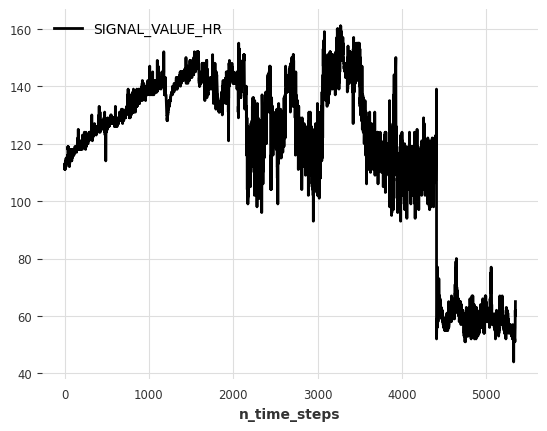

In [44]:
ts = ts_g[0]
ts['SIGNAL_VALUE_HR'].plot()

In [45]:
ts.pd_dataframe().columns

Index(['SIGNAL_VALUE_HR', 'SIGNAL_VALUE_SPO2', 'SPO2_binned'], dtype='object', name='component')

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
from darts.models import XGBModel

# extract covariate series
# ts_cov = ts[["SIGNAL_VALUE_SPO2","rolling_std_20_SIGNAL_VALUE_SPO2"]]
ts_cov = ts[["SIGNAL_VALUE_SPO2"]]

# ts_SPO2_std = ts["rolling_std_20_SIGNAL_VALUE_SPO2"]


# extract target series
ts_HR = ts["SIGNAL_VALUE_HR"]

# create train and validation splits
validation_cutoff = 3000
ts_HR_train, ts_HR_val = ts_HR.split_after(validation_cutoff)

# ts_HR.plot()
# plt.show()

# ts_SPO2.plot()
# plt.show()

/workspaces/ts-dl/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
ts_HR_train

<TimeSeries (DataArray) (n_time_steps: 3001, component: 1, sample: 1)> Size: 24kB
array([[[112.]],

       [[112.]],

       [[113.]],

       ...,

       [[134.]],

       [[102.]],

       [[129.]]])
Coordinates:
  * n_time_steps  (n_time_steps) int64 24kB 0 1 2 3 4 ... 2997 2998 2999 3000
  * component     (component) object 8B 'SIGNAL_VALUE_HR'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates   ID\ncomponent             \nSIGNA...
    hierarchy:          None

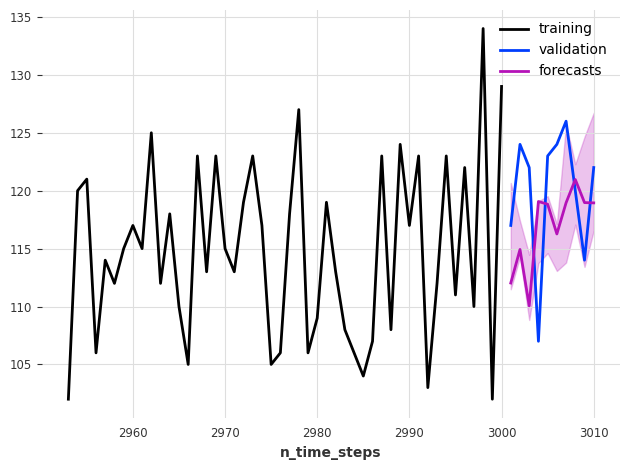

In [48]:
model = XGBModel(lags=20, 
                              output_chunk_length=10, 
                              lags_past_covariates=10,
                              multi_models=False,
                              likelihood='quantile', 
                              quantiles=[.2,.5,.8])
model.fit(ts_HR_train, past_covariates=ts_cov)
# pred = model.predict(10)

# ts_HR_train_tf[-48:].plot(label="training")
# ts_HR_val[:10].plot(label="validation")
# pred.plot(label="forecast")


pred_samples = model.predict(n=10, num_samples=200)
pred_params = model.predict(n=1, num_samples=1, predict_likelihood_parameters=True)

# for val, comp in zip(pred_params.values()[0], pred_params.components):
#     print(f"{comp} : {round(val, 3)}")

ts_HR_train[-48:].plot(label="training")
ts_HR_val[:10].plot(label="validation")
pred_samples.plot(label="forecasts")
plt.tight_layout()

# set up backtest methodology to do historical forecasts: https://unit8co.github.io/darts/quickstart/00-quickstart.html#Backtesting:-simulate-historical-forecasting

##### Local Evaluation

In [49]:
hfc_params = {
    "series": ts_HR,
    "start": validation_cutoff,  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 10,
    "num_samples": 200,
    "overlap_end":True,
    "verbose": False,
}

<Axes: xlabel='n_time_steps'>

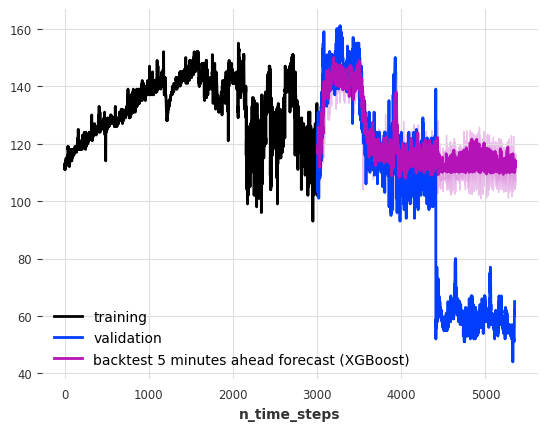

In [50]:
historical_fcast_lin_reg = model.historical_forecasts(
    last_points_only=True,
    past_covariates = ts_cov,
    retrain = False,
      **hfc_params
)

ts_HR_train.plot(label="training")
ts_HR_val.plot(label="validation")
historical_fcast_lin_reg.plot(label="backtest 5 minutes ahead forecast (XGBoost)")

In [51]:
from darts.metrics.metrics import mql, qr

print(mql(ts_HR_val,historical_fcast_lin_reg))
print(qr(ts_HR_val,historical_fcast_lin_reg))

25.18580156788558
0.2129826812145758


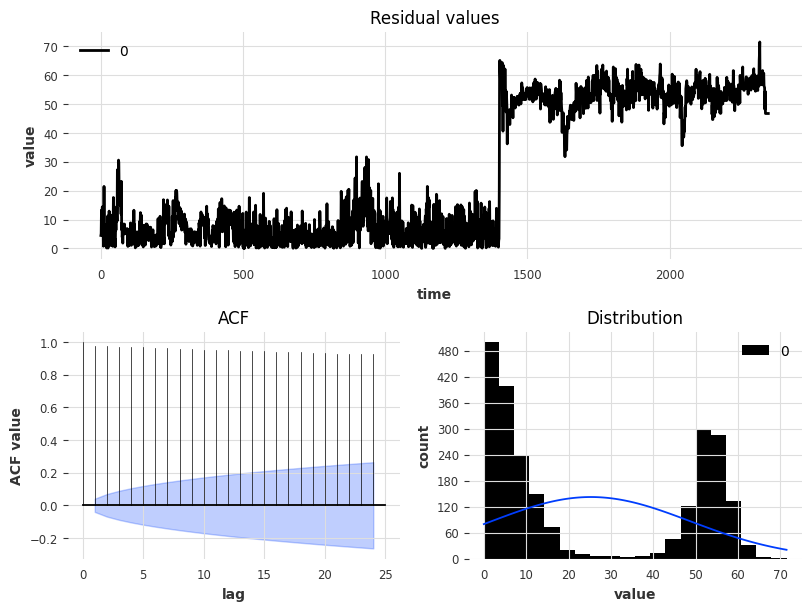

In [52]:
from darts.utils.statistics import plot_residuals_analysis
from darts.metrics.metrics import ae

residuals = model.residuals(
    historical_forecasts=historical_fcast_lin_reg,
    metric=ae,  # the absolute error per time step
    last_points_only=True,
    values_only=True,  # return a list of numpy arrays
    **hfc_params,
)
# residuals
plot_residuals_analysis(TimeSeries.from_values(residuals.squeeze()))



#### Global Model

In [53]:
ts_g_sample = ts_tf[:5]

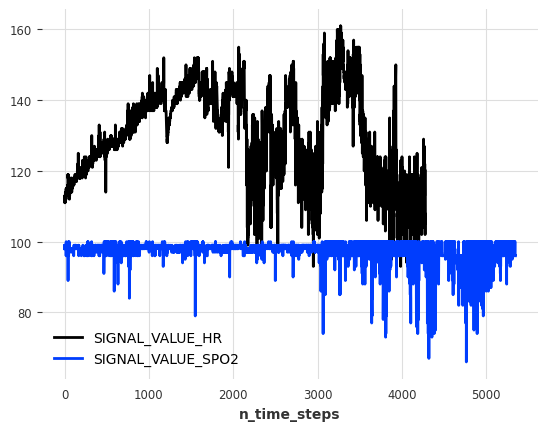

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
from darts.models import XGBModel

# extract covariate series
ts_g_cov = [ts[["SIGNAL_VALUE_SPO2"]] for ts in ts_g_sample]

# extract target series
ts_g_HR = [ts["SIGNAL_VALUE_HR"] for ts in ts_g_sample]

# create train and validation splits
validation_cutoff = 0.8
ts_splits = [ts.split_after(validation_cutoff) for ts in ts_g_HR]
ts_g_HR_train = [ts[0] for ts in ts_splits]
ts_g_HR_val = [ts[1] for ts in ts_splits]
# ts_HR_train, ts_HR_val = [ts_HR.split_after(validation_cutoff)]

ts_g_HR_train[0].plot()
ts_g_cov[0].plot()
plt.show()


In [55]:
model = XGBModel(lags=20, 
                              output_chunk_length=10, 
                              lags_past_covariates=10,
                              multi_models=False,
                              likelihood='quantile', 
                              quantiles=[.2,.5,.8])
model.fit(ts_g_HR_train, past_covariates=ts_g_cov)

XGBModel(lags=20, lags_past_covariates=10, lags_future_covariates=None, output_chunk_length=10, output_chunk_shift=0, add_encoders=None, likelihood=quantile, quantiles=[0.2, 0.5, 0.8], random_state=None, multi_models=False, use_static_covariates=True)

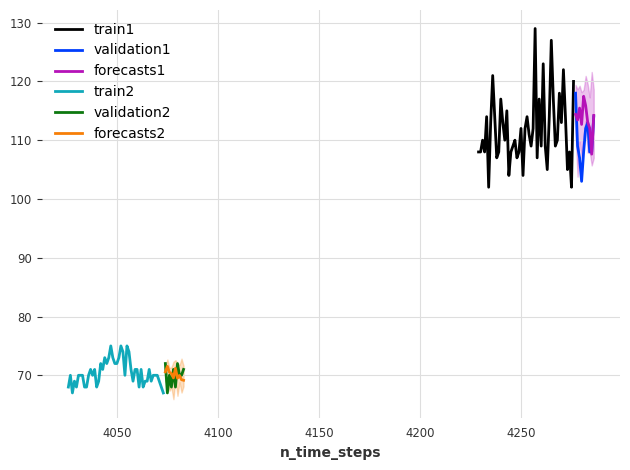

In [56]:
pred_samples = model.predict(series=ts_g_HR_train,
                             past_covariates=ts_g_cov,
                             n=10, 
                             num_samples=200)
# pred_params = model.predict(n=1, num_samples=1, predict_likelihood_parameters=True)

ts_g_HR_train[0][-48:].plot(label="train1")
ts_g_HR_val[0][:10].plot(label="validation1")
pred_samples[0].plot(label="forecasts1")


ts_g_HR_train[1][-48:].plot(label="train2")
ts_g_HR_val[1][:10].plot(label="validation2")
pred_samples[1].plot(label="forecasts2")
plt.tight_layout()

Baseline models show that predictions not well calibrated, validation is too often outside 80% CI

##### Global Evaluation

In [57]:
hfc_params = {
    "series": ts_g_HR,
    "start": validation_cutoff,  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 10,
    "num_samples": 200,
    "overlap_end":True,
    "verbose": False,
}

<Axes: xlabel='n_time_steps'>

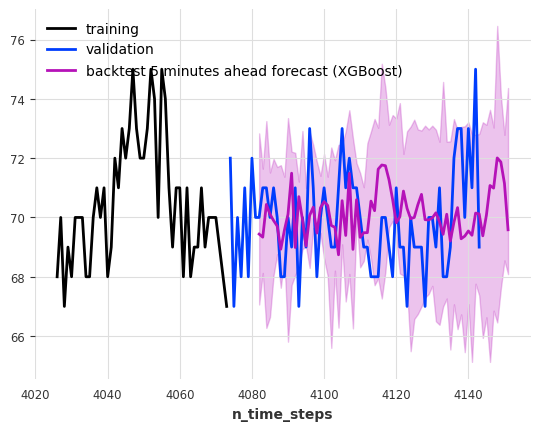

In [58]:
historical_fcast_lin_reg = model.historical_forecasts(
    last_points_only=True,
    past_covariates = ts_g_cov,
    retrain = False,
      **hfc_params
)

ts_g_HR_train[1].tail(48).plot(label="training")
ts_g_HR_val[1][:70].plot(label="validation")
historical_fcast_lin_reg[1][:70].plot(label="backtest 5 minutes ahead forecast (XGBoost)")

###### Note
Example of a forecast miss? slow to react to dropping heart rate?

In [59]:
print(mql(ts_g_HR_val,historical_fcast_lin_reg))
print(qr(ts_g_HR_val,historical_fcast_lin_reg))

[4.500497246560796, 3.2902109624399603, 4.6136583553313, 1.1696448591620967e-10, 3.9337110720762913]
[0.0834004502625721, 0.003471441755050177, 0.020303216048808068, inf, 0.0035637409076653775]


/workspaces/ts-dl/.venv/lib/python3.10/site-packages/darts/metrics/metrics.py:3116: RuntimeWarning: divide by zero encountered in divide
  return losses / z_true


### Deep Learning Models

In [60]:
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts import concatenate
from darts.dataprocessing.transformers.scaler import Scaler
from darts.metrics import mql
from darts.models import TFTModel, TSMixerModel
from darts.utils.callbacks import TFMProgressBar
from darts.utils.likelihood_models import QuantileRegression

#### Darts Implementation

In [61]:
# ts_dl_sample = [ts for ts in train[:5]]

# train, val, test = [], [], []
# for ts in ts_dl_sample:
#     train_, temp = ts.split_after(0.6)
#     val_, test_ = temp.split_after(0.5)
#     train.append(train_)
#     val.append(val_)
#     test.append(test_)

In [62]:
# train[0].pd_dataframe().shape

In [63]:
# from darts.dataprocessing.transformers import Scaler

# scaler = Scaler()  # default uses sklearn's MinMaxScaler
# train = scaler.fit_transform(train)
# val = scaler.transform(val)
# test = scaler.transform(test)

In [64]:
def create_params(
    input_chunk_length: int,
    output_chunk_length: int,
    full_training=True,
):
    # early stopping: this setting stops training once the the validation
    # loss has not decreased by more than 1e-5 for 10 epochs
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=1e-5,
        mode="min",
    )

    # PyTorch Lightning Trainer arguments (you can add any custom callback)
    if full_training:
        limit_train_batches = None
        limit_val_batches = None
        max_epochs = 200
        batch_size = 256
    else:
        limit_train_batches = 20
        limit_val_batches = 10
        max_epochs = 20 # was originally 40
        batch_size = 64

    # only show the training and prediction progress bars
    progress_bar = TFMProgressBar(
        enable_sanity_check_bar=False, enable_validation_bar=False
    )
    pl_trainer_kwargs = {
        "gradient_clip_val": 1,
        "max_epochs": max_epochs,
        "limit_train_batches": limit_train_batches,
        "limit_val_batches": limit_val_batches,
        "accelerator": "auto",
        "callbacks": [early_stopper, progress_bar],
    }

    # optimizer setup, uses Adam by default
    # optimizer_cls = torch.optim.Adam
    optimizer_kwargs = {
        "lr": 1e-4,
        "weight_decay":1e-4
    }

    # learning rate scheduler
    lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
    lr_scheduler_kwargs = {"gamma": 0.999}

    # for probabilistic models, we use quantile regression, and set `loss_fn` to `None`
    likelihood = QuantileRegression()
    loss_fn = None

    return {
        "input_chunk_length": input_chunk_length,  # lookback window
        "output_chunk_length": output_chunk_length,  # forecast/lookahead window
        "use_reversible_instance_norm": True,
        "optimizer_kwargs": optimizer_kwargs,
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": lr_scheduler_kwargs,
        "likelihood": likelihood,  # use a `likelihood` for probabilistic forecasts
        "loss_fn": loss_fn,  # use a `loss_fn` for determinsitic model
        "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
        "force_reset": True,
        "batch_size": batch_size,
        "random_state": 42,
        # "add_encoders": {
        #     "cyclic": {
        #         "future": ["hour", "dayofweek", "month"]
        #     }  # add cyclic time axis encodings as future covariates
        # },
    }

In [65]:
input_chunk_length = 10 # use previous 10 timestamps to predict next 10
output_chunk_length = 10
use_static_covariates = True
full_training = False

In [66]:
model_tsm = TSMixerModel(
    **create_params(
        input_chunk_length,
        output_chunk_length,
        full_training=full_training,
    ),
    use_static_covariates=use_static_covariates,
    dropout=0.5,
    model_name="tsm",
)

model_tfm = TFTModel(
    **create_params(
        input_chunk_length,
        output_chunk_length,
        full_training=full_training
    ),
    use_static_covariates=use_static_covariates,
    dropout=0.5,
    add_relative_index=True,
    model_name="tfm",
)

In [67]:
models = {
    "TSM": model_tsm,
    "TFM": model_tfm
}

In [68]:
for model_name, model in models.items():
    model.fit(
        series=train,
        val_series=val,
    )
    # load from checkpoint returns a new model object, we store it in the models dict
    models[model_name] = model.load_from_checkpoint(
        model_name=model.model_name, best=True
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | train_metrics       | MetricCollection | 0      | train
1 | val_metrics         | MetricCollection | 0      | train
2 | rin                 | RINorm           | 164    | train
3 | fc_hist             | Linear           | 110    | train
4 | feature_mixing_hist | _FeatureMixing   | 16.1 K | train
5 | conditional_mixer   | ModuleList       | 60.6 K | train
6 | fc_out              | Linear           | 90.6 K | train
-----------------------------------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.670     Total estimated model params size (MB)
59        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 22.50it/s, train_loss=0.260, val_loss=0.450]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 20.94it/s, train_loss=0.260, val_loss=0.450]


/workspaces/ts-dl/.venv/lib/python3.10/site-packages/darts/models/forecasting/torch_forecasting_model.py:1833: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchFore

Epoch 19: 100%|██████████| 20/20 [00:03<00:00,  5.75it/s, train_loss=0.255, val_loss=0.536]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s, train_loss=0.255, val_loss=0.536]

/workspaces/ts-dl/.venv/lib/python3.10/site-packages/darts/models/forecasting/torch_forecasting_model.py:1833: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchFore

In [69]:
# concatenate val and test for backtesting
# val_test = [ts[0].concatenate(ts[1]) for ts in zip(val,test)]

In [70]:
# configure the probabilistic prediction
num_samples = 100 # was 200
forecast_horizon = output_chunk_length

# compute the Mean Quantile Loss over these quantiles
evaluate_quantiles = [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95]


def historical_forecasts(model):
    """Generates probabilistic historical forecasts for each transformer
    and returns the inverse transformed results.

    Each forecast covers 24h (forecast_horizon). The time between two forecasts
    (stride) is also 24 hours.
    """
    hfc = model.historical_forecasts(
        series=test[:5],
        forecast_horizon=forecast_horizon,
        stride=1,
        last_points_only=True,
        retrain=False,
        num_samples=num_samples, # was num_samples
        # predict_likelihood_parameters = True, # did not exist
        verbose=True,
        predict_kwargs = {"mc_dropout":True}
    )
    return scaler.inverse_transform(hfc)


def backtest(model, hfc, name):
    """Evaluates probabilistic historical forecasts using the Mean Quantile
    Loss (MQL) over a set of quantiles."""
    # add metric specific kwargs
    metric_kwargs = [{"q": q} for q in evaluate_quantiles]
    metrics = [mql for _ in range(len(evaluate_quantiles))]
    bt = model.backtest(
        series=test[:5],
        historical_forecasts=hfc,
        last_points_only=True,
        metric=metrics,
        metric_kwargs=metric_kwargs,
        verbose=True,
    )
    # bt = pd.DataFrame(
    #     bt,
    #     columns=[f"q_{q}" for q in evaluate_quantiles],
    #     index=[f"{trafo}_{name}" for trafo in ["SIGNAL_VALUE_HR"]],
    # )
    return bt


def generate_plots(n_days, hfcs):
    """Plot the probabilistic forecasts for each model, transformer and transformer
    feature against the ground truth."""
    # concatenate historical forecasts into contiguous time series
    # (works because forecast_horizon=stride)
    hfcs_plot = {}
    for model_name, hfc_model in hfcs.items():
        hfcs_plot[model_name] = [
            concatenate(hfc_series[-n_days:], axis=0) for hfc_series in hfc_model
        ]

    # remember start and end points for plotting the target series
    hfc_ = hfcs_plot[model_name][0]
    start, end = hfc_.start_time(), hfc_.end_time()

    # for each target column...
    for col in ts_g_sample[0].columns:
        fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
        # ... and for each transformer...
        for trafo_idx, trafo in enumerate(ts_g_sample):
            trafo[col][start:end].plot(label="ground truth", ax=axes[trafo_idx])
            # ... plot the historical forecasts for each model
            for model_name, hfc in hfcs_plot.items():
                hfc[trafo_idx][col].plot(
                    label=model_name + "_q0.05-q0.95", ax=axes[trafo_idx]
                )
            axes[trafo_idx].set_title(f"ETTh{trafo_idx + 1}: {col}")
        plt.show()

In [71]:
bts = {}
hfcs = {}
for model_name, model in models.items():
    print(f"Model: {model_name}")
    print("Generating historical forecasts..")
    hfcs[model_name] = historical_forecasts(models[model_name])

    print("Evaluating historical forecasts..")
    bts[model_name] = backtest(models[model_name], hfcs[model_name], model_name)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model: TSM
Generating historical forecasts..
Predicting: 0it [00:00, ?it/s]

Predicting DataLoader 0: 100%|██████████| 64/64 [01:06<00:00,  1.04s/it]

Only 5 TimeSeries (lists) were provided which is lower than the number of series (n=266) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.



Evaluating historical forecasts..


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model: TFM
Generating historical forecasts..
Predicting DataLoader 0: 100%|██████████| 64/64 [04:16<00:00,  4.01s/it]

Only 5 TimeSeries (lists) were provided which is lower than the number of series (n=266) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.



Evaluating historical forecasts..


<Axes: xlabel='time'>

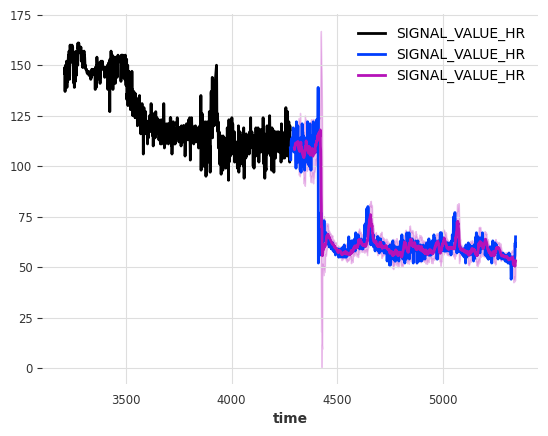

In [72]:
# scaler.inverse_transform(train)[0].plot()
# scaler.inverse_transform(train)[0]['SIGNAL_VALUE_HR'].plot()
scaler.inverse_transform(val)[0]['SIGNAL_VALUE_HR'].plot()
scaler.inverse_transform(test)[0]['SIGNAL_VALUE_HR'].plot()
hfcs['TSM'][0]['SIGNAL_VALUE_HR'].plot()

<Axes: xlabel='time'>

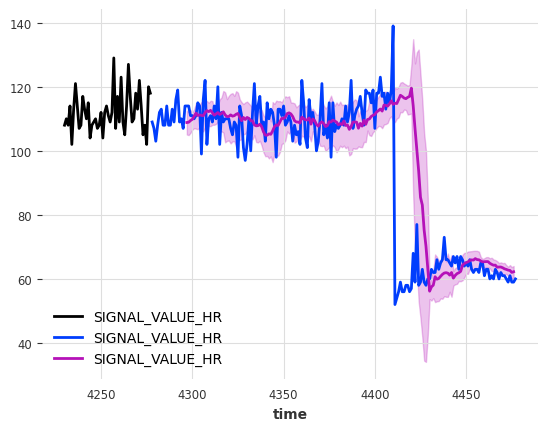

In [73]:
# scaler.inverse_transform(train)[0].plot()
scaler.inverse_transform(val)[0].tail(48)['SIGNAL_VALUE_HR'].plot()
scaler.inverse_transform(test)[0].head(200)['SIGNAL_VALUE_HR'].plot()
hfcs['TFM'][0].head(180)['SIGNAL_VALUE_HR'].plot()

###### Note
^ Interesting that CI is large, that itself can be part of prediction envelope

## Prediction Envelope

In [74]:
# spread of HR
hfcs_tfm_spreads = [ts.quantiles_df([.5,.2,.8])[['SIGNAL_VALUE_HR_0.5',
                                                 'SIGNAL_VALUE_HR_0.2',
                                                 'SIGNAL_VALUE_HR_0.8',
                                                 ]].assign(ID=ts.static_covariates['ID'][0]) for ts in hfcs['TFM']]
hfcs_tfm_spreads
hfcs_tfm_spread = pd.concat(hfcs_tfm_spreads)
hfcs_tfm_spread['HR_SPREAD'] = hfcs_tfm_spread['SIGNAL_VALUE_HR_0.8'] -  hfcs_tfm_spread['SIGNAL_VALUE_HR_0.2']
hfcs_tfm_spread['HR_SPREAD_PERCENTILE'] = hfcs_tfm_spread['HR_SPREAD'].rank(pct=True)


concern_threshold = .95
hfcs_tfm_spread['concern_indicator'] =  (hfcs_tfm_spread['HR_SPREAD_PERCENTILE'] > concern_threshold).astype(int)
hfcs_tfm_spread['rolling_concern_indicator'] = (
    hfcs_tfm_spread['concern_indicator']
    .groupby((hfcs_tfm_spread['concern_indicator'] != 1).cumsum())  # Create groups for consecutive 1s
    .cumcount()                               # Count within each group
) * hfcs_tfm_spread['concern_indicator']  # Reset count to 0 for 0s
hfcs_tfm_spread[120:130]

component,SIGNAL_VALUE_HR_0.5,SIGNAL_VALUE_HR_0.2,SIGNAL_VALUE_HR_0.8,ID,HR_SPREAD,HR_SPREAD_PERCENTILE,concern_indicator,rolling_concern_indicator
time,,,,,,,,
4417,116.289098,114.243785,118.252742,1.0,4.008957,0.779653,0,0
4418,116.703217,114.644157,118.299708,1.0,3.655551,0.732697,0,0
4419,116.986816,113.897789,118.646140,1.0,4.748351,0.845439,0,0
4420,119.573544,115.401949,123.029963,1.0,7.628014,0.960382,1,1
4421,114.081943,97.817346,124.444514,1.0,26.627168,0.998288,1,2
4422,106.916457,90.292006,118.527152,1.0,28.235146,0.998777,1,3
4423,100.415719,83.518834,115.654315,1.0,32.135481,0.999266,1,4
4424,93.665763,74.556961,109.501721,1.0,34.944760,1.000000,1,5
4425,85.468286,74.781013,102.060464,1.0,27.279451,0.998533,1,6


In [75]:
train[0]['SIGNAL_VALUE_HR'].median(axis=0)

<TimeSeries (DataArray) (n_time_steps: 1, component: 1, sample: 1)> Size: 8B
array([[[0.60606061]]])
Coordinates:
  * n_time_steps  (n_time_steps) int64 8B 0
  * component     (component) object 8B 'SIGNAL_VALUE_HR'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates   ID\ncomponent             \nSIGNA...
    hierarchy:          None

In [76]:
bt_tsm = pd.DataFrame(
        bts['TSM'],
        columns=[f"q_{q}" for q in evaluate_quantiles],
        # index=[f"{series}_{name}" for trafo in ["SIGNAL_VALUE_HR"]],
    )
bt_tsm

,q_0.05,q_0.1,q_0.2,q_0.5,q_0.8,q_0.9,q_0.95
0,70.659189,67.262182,60.339245,39.100102,17.255522,9.840466,6.101406
1,67.707038,64.327143,57.473147,36.610139,15.332954,8.141635,4.523105
2,64.524989,61.363019,54.901474,35.060329,14.645888,7.698443,4.192484
3,53.648340,51.046644,45.834923,30.179108,14.378075,9.076130,6.420029
4,76.455391,72.644802,64.927285,41.432728,17.473746,9.374221,5.297097


In [77]:
bt_tfm = pd.DataFrame(
        bts['TFM'],
        columns=[f"q_{q}" for q in evaluate_quantiles],
        # index=[f"{series}_{name}" for trafo in ["SIGNAL_VALUE_HR"]],
    )
bt_tfm

,q_0.05,q_0.1,q_0.2,q_0.5,q_0.8,q_0.9,q_0.95
0,71.417130,67.916284,60.820350,39.149124,17.189733,9.811081,6.106293
1,68.254245,64.804396,57.833647,36.644481,15.272303,8.107621,4.514625
2,65.313777,62.043949,55.405101,35.113192,14.551990,7.641546,4.171917
3,53.790215,51.186392,45.950178,30.170010,14.345977,9.061615,6.416544
4,77.062035,73.180673,65.335941,41.472006,17.405230,9.336219,5.290033


In [78]:
bt_tfm.mean().mean()

36.34531007717015

#### Deep Learning Explainability

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.12it/s]


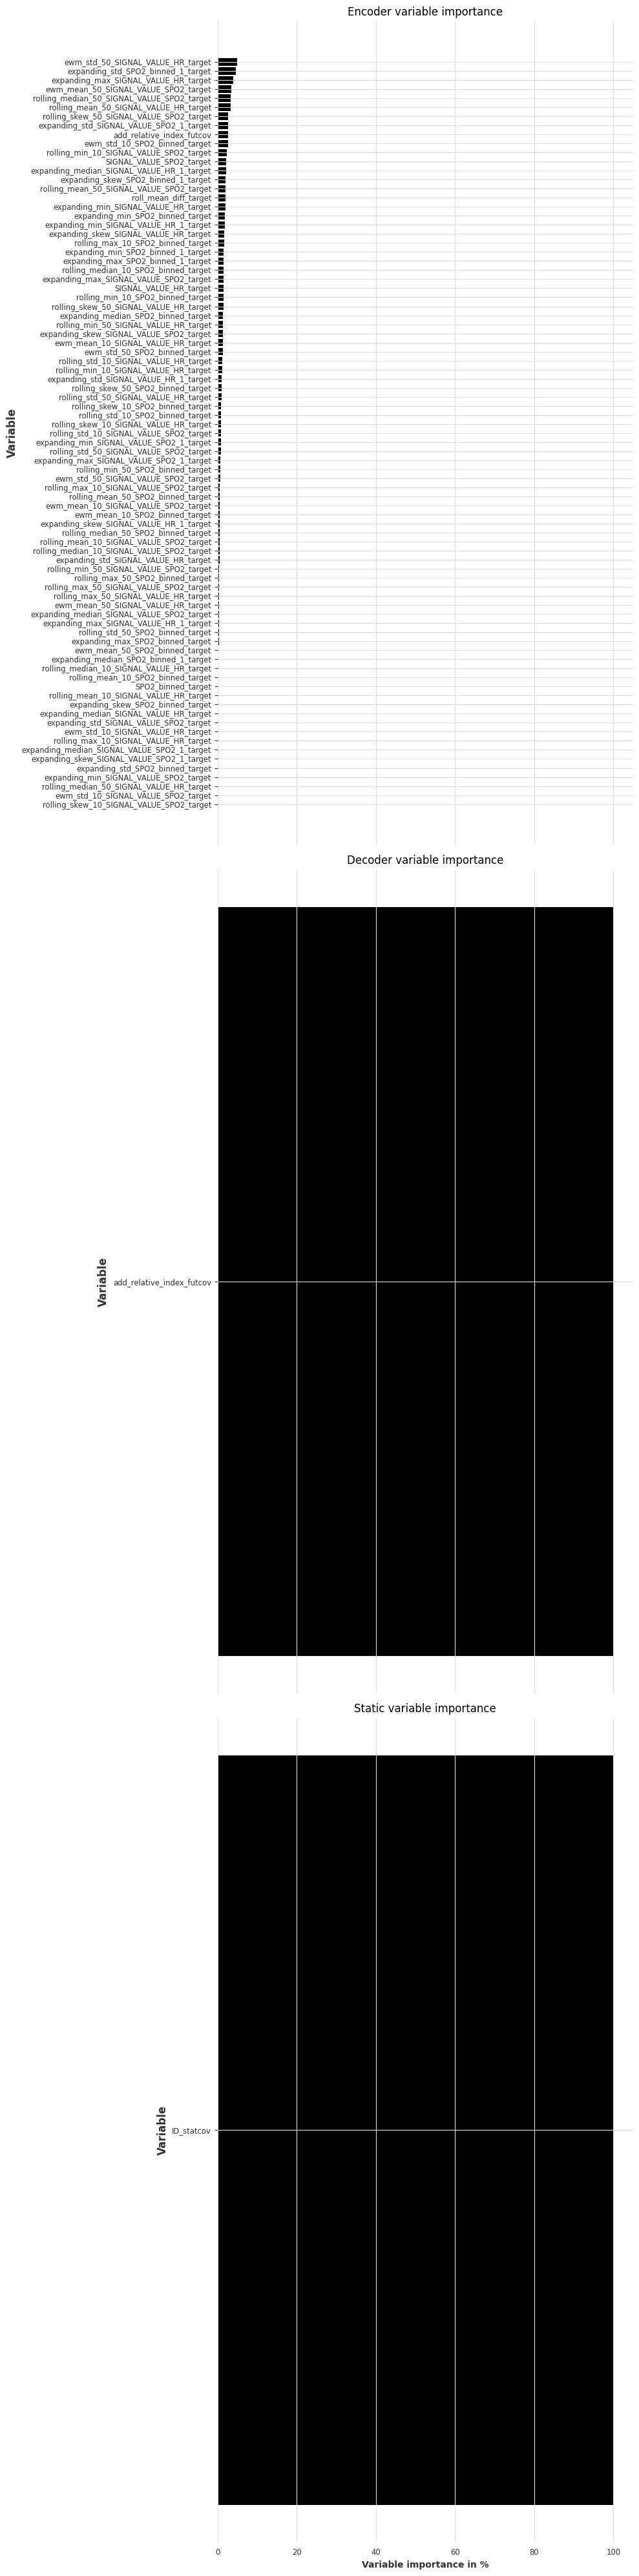

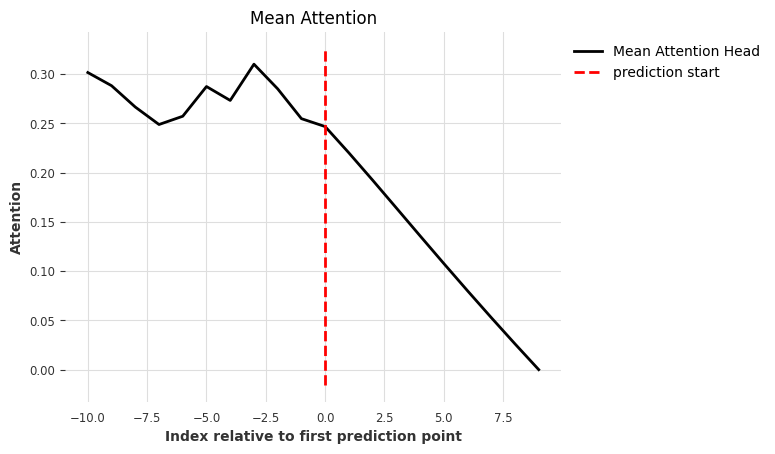

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [79]:
from darts.explainability import TFTExplainer
explainer = TFTExplainer(model_tfm,
                         background_series=test[0])
explainability_result = explainer.explain()
explainer.plot_variable_selection(explainability_result,fig_size=[10,40])
explainer.plot_attention(explainability_result, plot_type="time")

# Notes

- https://unit8co.github.io/darts/userguide/forecasting_overview.html#handling-multiple-series see probabilistic NN section